In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
from adjustText import adjust_text 
import pickle 
import math
import scanpy as sc
import pandas as pd

In [2]:
adata_real = sc.read_h5ad("/gpfs/home/asun/jin_lab/perturbench/studies/storm/outputs/test/storm/2025-11-19_16-14-33/test_storm_NTsubset/test_storm_NTsubset_run/eval_final.ckpt/adata_pred.h5ad")
adata_pred = sc.read_h5ad("/gpfs/home/asun/jin_lab/perturbench/studies/storm/outputs/test/storm/2025-11-19_16-14-33/test_storm_NTsubset/test_storm_NTsubset_run/eval_final.ckpt/adata_real.h5ad")

In [3]:
adata_real.obs.groupby(["Assign", "predicted.subclass"]).size()

/tmp/ipykernel_11345/1223974036.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_real.obs.groupby(["Assign", "predicted.subclass"]).size()


Assign    predicted.subclass
Bcl11b_0  CT SUB                 301
          L2-3 IT CTX-2            0
          L3 RSP-ACA               0
          L5 IT CTX              360
          L6 CT CTX             1320
          L6 IT CTX                0
          Sst                    171
          Vip                     21
Dab1_0    CT SUB                   0
          L2-3 IT CTX-2            0
          L3 RSP-ACA               0
          L5 IT CTX                0
          L6 CT CTX                0
          L6 IT CTX                0
          Sst                      0
          Vip                     14
Herc1_0   CT SUB                   0
          L2-3 IT CTX-2           72
          L3 RSP-ACA               0
          L5 IT CTX              109
          L6 CT CTX                0
          L6 IT CTX                0
          Sst                     61
          Vip                      0
NT_0      CT SUB                  42
          L2-3 IT CTX-2            6
         

In [6]:
adata_real.var

,gene_names
0,Xkr4
1,Gm1992
2,Gm19938
3,Gm37381
4,Rp1
...,...
32280,AC124606.1
32281,AC133095.2
32282,AC133095.1
32283,AC234645.1


In [4]:
# counts per Assign x predicted.subclass
ct = (
    adata_real.obs
    .groupby(["Assign", "predicted.subclass"])
    .size()
    .unstack(fill_value=0)
)

print(ct)

predicted.subclass  CT SUB  L2-3 IT CTX-2  L3 RSP-ACA  L5 IT CTX  L6 CT CTX  \
Assign                                                                        
Bcl11b_0               301              0           0        360       1320   
Dab1_0                   0              0           0          0          0   
Herc1_0                  0             72           0        109          0   
NT_0                    42              6           4         41        126   
Trio_0                 180              0          55          0          0   

predicted.subclass  L6 IT CTX  Sst  Vip  
Assign                                   
Bcl11b_0                    0  171   21  
Dab1_0                      0    0   14  
Herc1_0                     0   61    0  
NT_0                       29   25    2  
Trio_0                    377    0    0  


/tmp/ipykernel_11345/3236139854.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["Assign", "predicted.subclass"])


In [8]:
import numpy as np
import pandas as pd
from scipy import sparse

def calculate_logfc(adata, cell_type_value, perturbation_value, control_value="NT_0", 
                   cell_type_col="predicted.subclass", condition_col="Assign", 
                   gene_name_col="gene_names", pseudocount=0.1):
    """
    Calculate log2 fold change between perturbation and control for a specific cell type.
    
    Parameters:
    - adata: AnnData object
    - cell_type_value: Cell type to filter (e.g., "L6_CT_CTX")
    - perturbation_value: Perturbation condition (e.g., "TBR1")
    - control_value: Control condition (default: "ctrl")
    - cell_type_col: Column name for cell type in adata.obs (default: "cell_type")
    - condition_col: Column name for condition in adata.obs (default: "condition")
    - gene_name_col: Column name for gene names in adata.var (default: "gene_name")
    - pseudocount: Pseudocount to add before log transformation (default: 0.1)
    
    Returns:
    - logfc_df: DataFrame with gene names as columns and logFC values as a single row
    """
    
    # Get perturbation condition average
    mask_p = (adata.obs[condition_col] == perturbation_value) & \
             (adata.obs[cell_type_col] == cell_type_value)
    
    X = adata.X
    avg_p = X[mask_p].mean(axis=0)
    avg_p = avg_p.A1 if sparse.issparse(avg_p) else np.asarray(avg_p).ravel()
    
    # Get control condition average
    mask_ctrl = (adata.obs[condition_col] == control_value) & \
                (adata.obs[cell_type_col] == cell_type_value)
    
    avg_ctrl = X[mask_ctrl].mean(axis=0)
    avg_ctrl = avg_ctrl.A1 if sparse.issparse(avg_ctrl) else np.asarray(avg_ctrl).ravel()
    
    # Calculate log2 fold change
    avg_p_log = np.log2(avg_p + pseudocount)
    avg_ctrl_log = np.log2(avg_ctrl + pseudocount)

    logfc = avg_p_log - avg_ctrl_log

    # # scanpy calculate logfc 
    # epsilon = 1e-9
    # avg_p_log = np.expm1(avg_p) + epsilon
    # avg_ctrl_log = np.expm1(avg_ctrl) + epsilon

    # logfc = np.log2(avg_p_log / avg_ctrl_log)
    
    # Create dataframe with gene names as columns and logFC as a single row
    gene_names = adata.var[gene_name_col]
    logfc_df = pd.DataFrame([logfc], columns=gene_names)
    
    return logfc_df

In [9]:
logfc_df_pred = calculate_logfc(adata_pred, cell_type_value="CT SUB", perturbation_value="Bcl11b_0")
logfc_df_real = calculate_logfc(adata_real, cell_type_value="CT SUB", perturbation_value="Bcl11b_0")


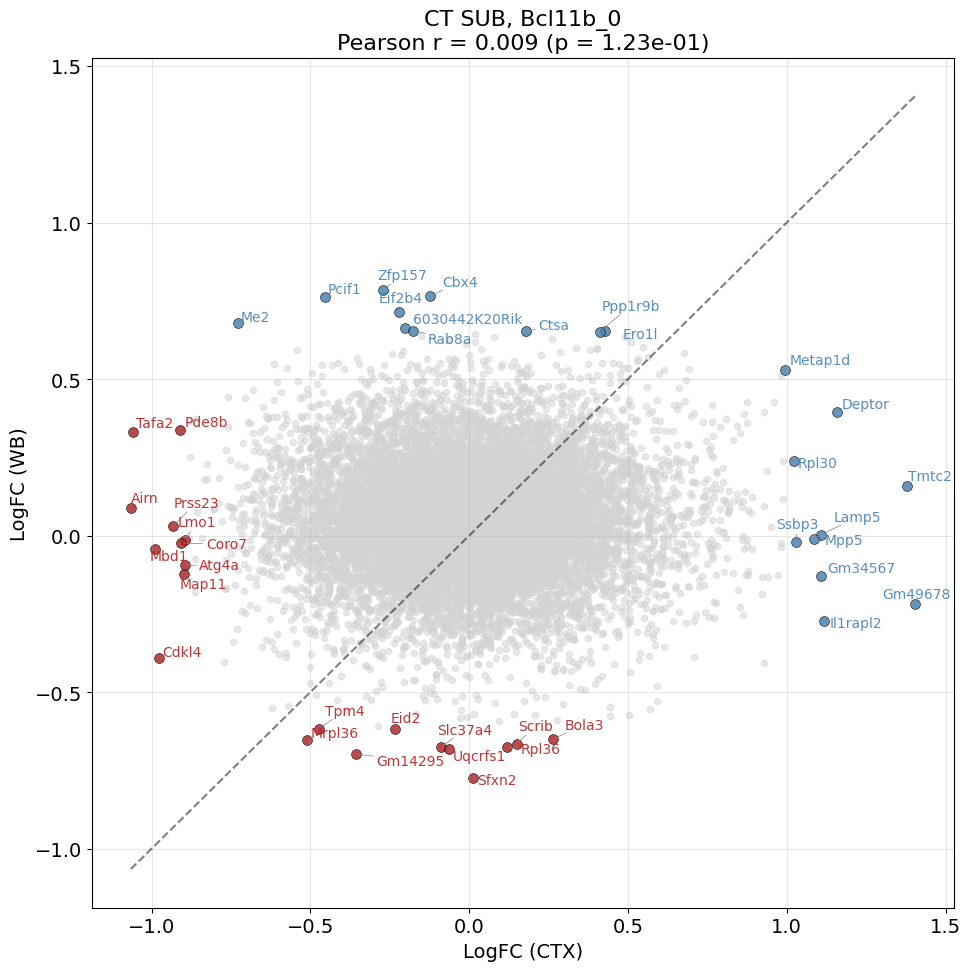

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from adjustText import adjust_text

# Assuming you have logfc_df_ctx and logfc_df_wb
# Both should have the same gene columns

# Get common genes between the two datasets
common_genes = logfc_df_pred.columns.intersection(logfc_df_real.columns)

# Extract logFC values for common genes
x_vals = logfc_df_pred[common_genes].values[0]
y_vals = logfc_df_real[common_genes].values[0]

# Calculate correlation
pearson_r, p_value = pearsonr(x_vals, y_vals)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Scatter plot
ax.scatter(x_vals, y_vals, alpha=0.5, color="lightgray", s=20)

# Identity line
min_val = min(x_vals.min(), y_vals.min())
max_val = max(x_vals.max(), y_vals.max())
ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='y=x')

# Labels and title
ax.set_xlabel("LogFC (CTX)", fontsize=14)
ax.set_ylabel("LogFC (WB)", fontsize=14)
ax.set_title(f"CT SUB, Bcl11b_0\nPearson r = {pearson_r:.3f} (p = {p_value:.2e})", fontsize=16)
ax.grid(True, alpha=0.3)

# Highlight top/bottom genes
top10_ctx_idx = np.argsort(x_vals)[-10:]
bottom10_ctx_idx = np.argsort(x_vals)[:10]
top10_wb_idx = np.argsort(y_vals)[-10:]
bottom10_wb_idx = np.argsort(y_vals)[:10]

# Combine indices for labeling (genes that are extreme in either dataset)
genes_to_label = set(top10_ctx_idx).union(set(bottom10_ctx_idx)).union(
                     set(top10_wb_idx)).union(set(bottom10_wb_idx))

# Color coding
texts = []
for idx in genes_to_label:
    if idx in top10_ctx_idx or idx in top10_wb_idx:
        color = "steelblue"
    else:
        color = "firebrick"
    
    # Scatter the highlighted points
    ax.scatter(x_vals[idx], y_vals[idx], color=color, s=50, alpha=0.8, edgecolors='black', linewidths=0.5)
    
    # Add text label
    texts.append(
        ax.text(
            x_vals[idx], y_vals[idx], common_genes[idx],
            fontsize=10,
            color=color,
            alpha=0.9
        )
    )

# Adjust text to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5), ax=ax)

plt.tight_layout()
plt.show()

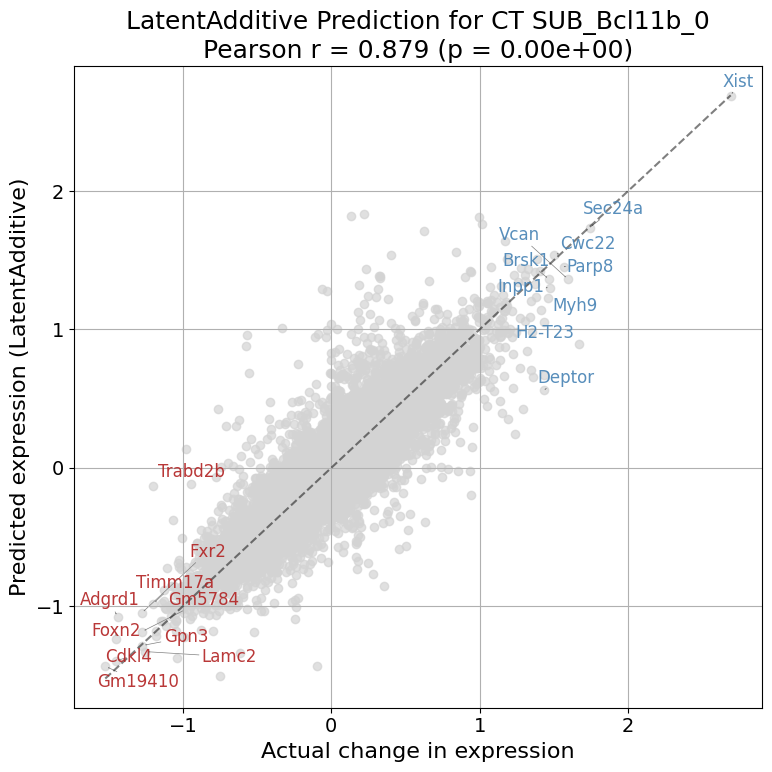

No DEGs found for CT SUB_Bcl11b_0, skipping DEG plot


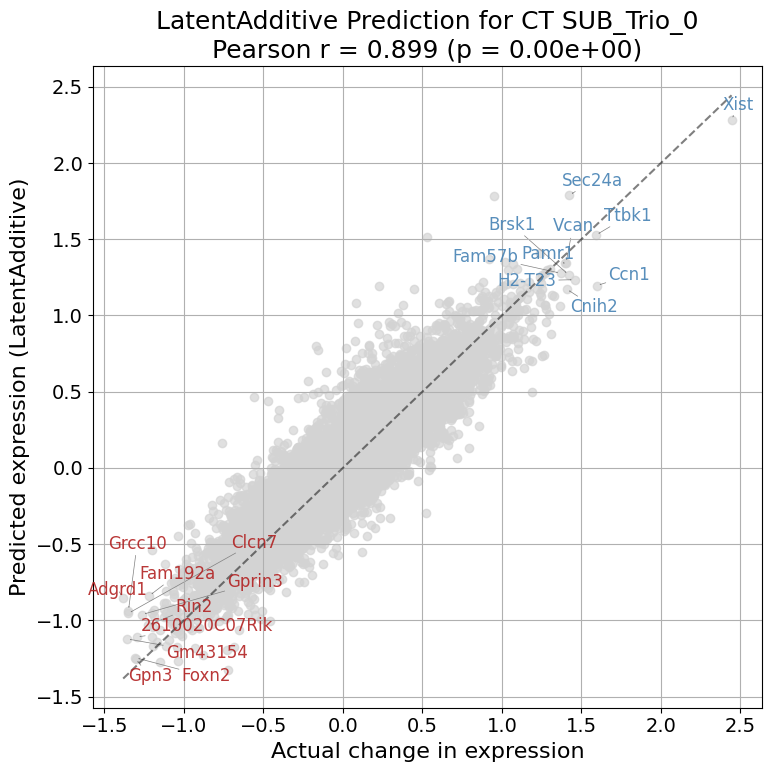

No DEGs found for CT SUB_Trio_0, skipping DEG plot


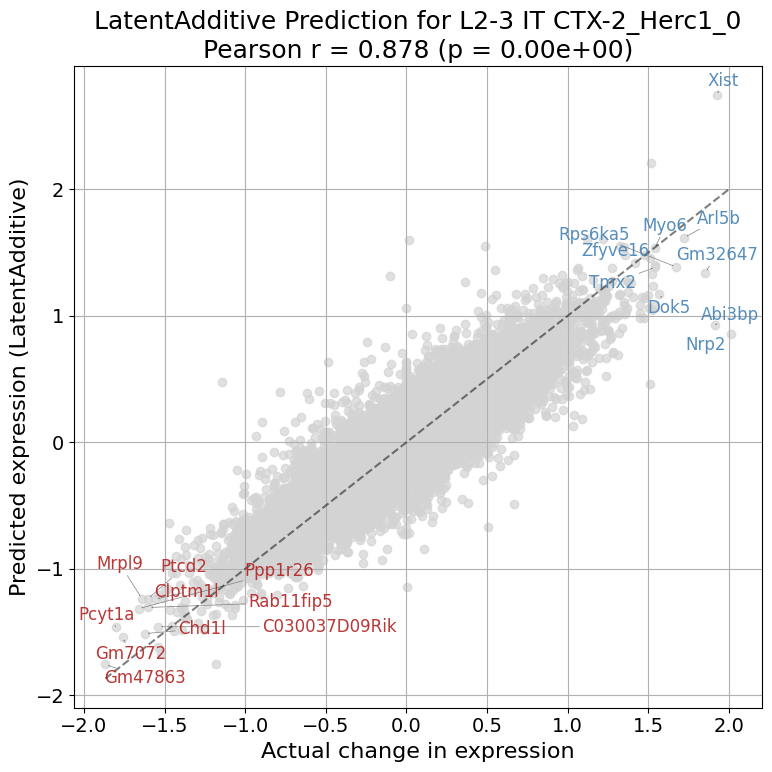

No DEGs found for L2-3 IT CTX-2_Herc1_0, skipping DEG plot


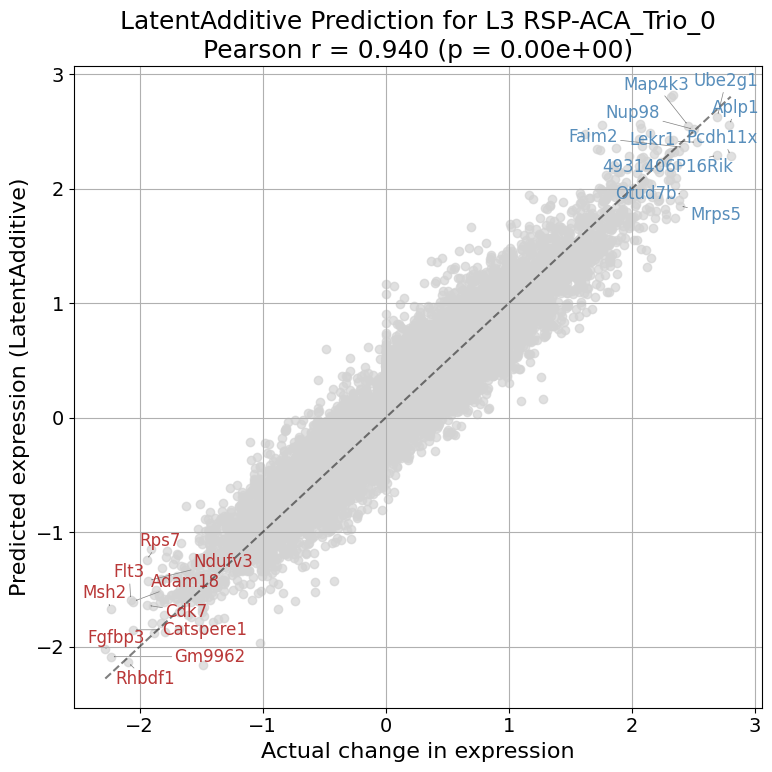

No DEGs found for L3 RSP-ACA_Trio_0, skipping DEG plot


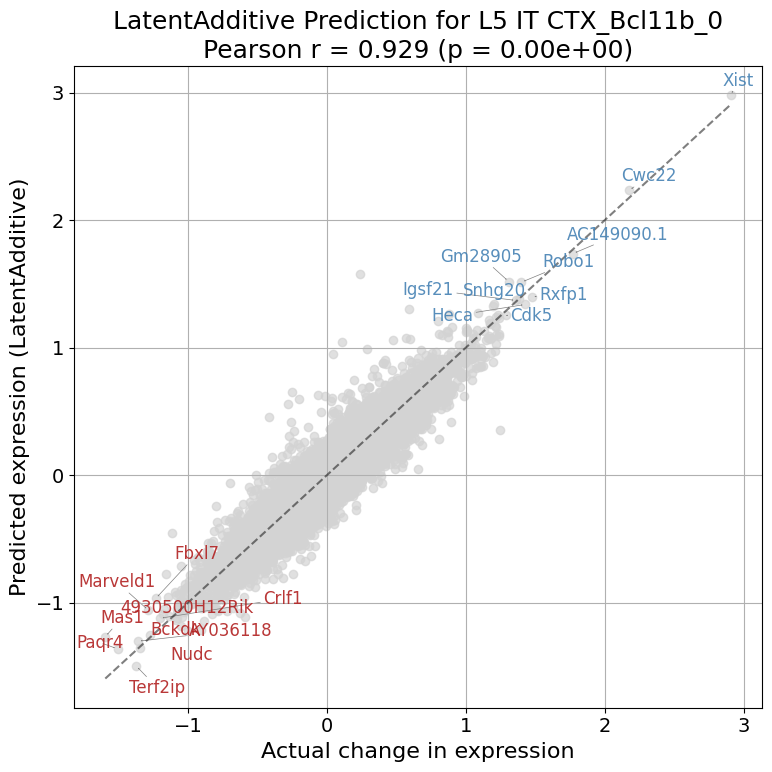

No DEGs found for L5 IT CTX_Bcl11b_0, skipping DEG plot


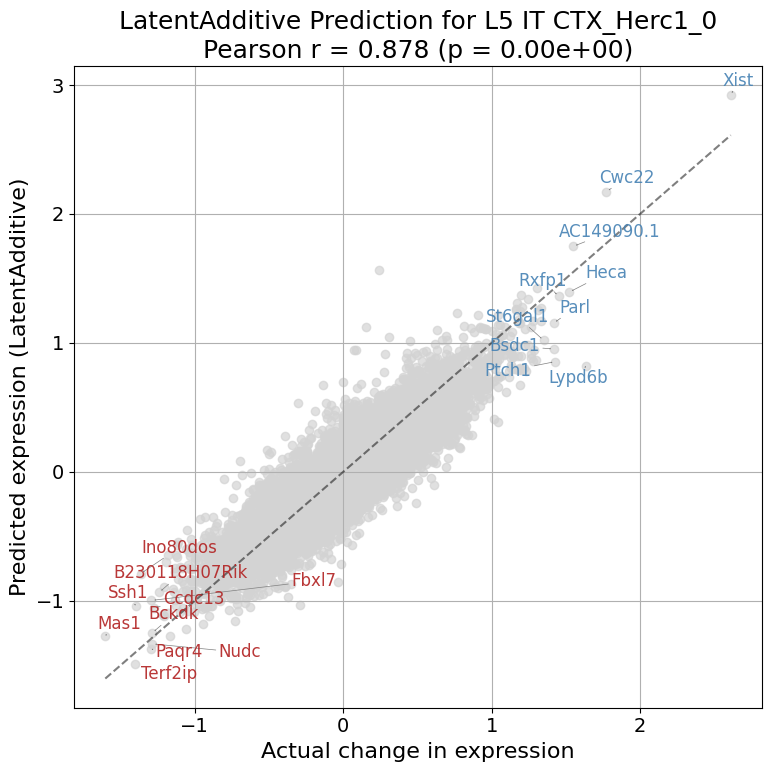

No DEGs found for L5 IT CTX_Herc1_0, skipping DEG plot


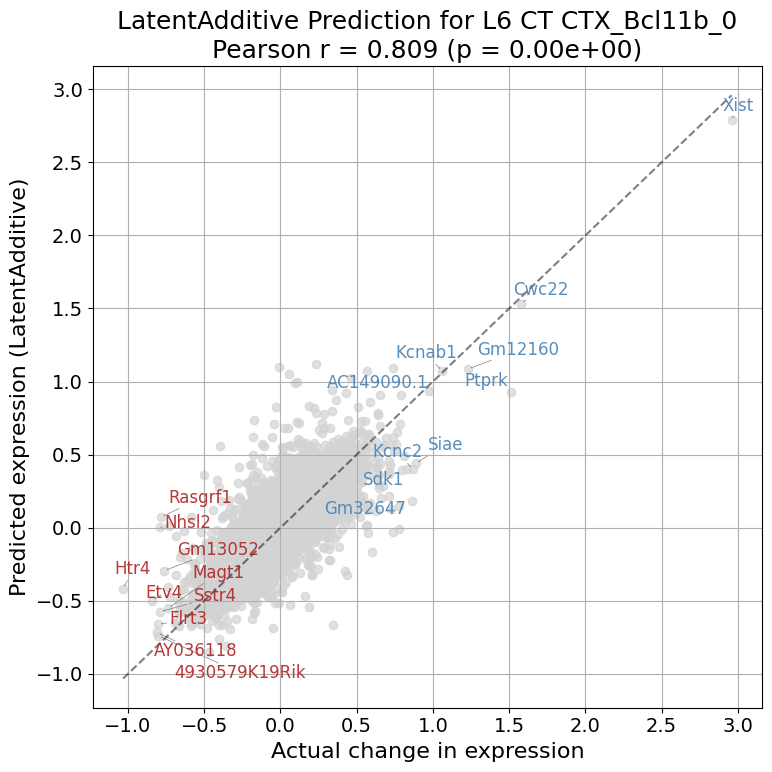

No DEGs found for L6 CT CTX_Bcl11b_0, skipping DEG plot


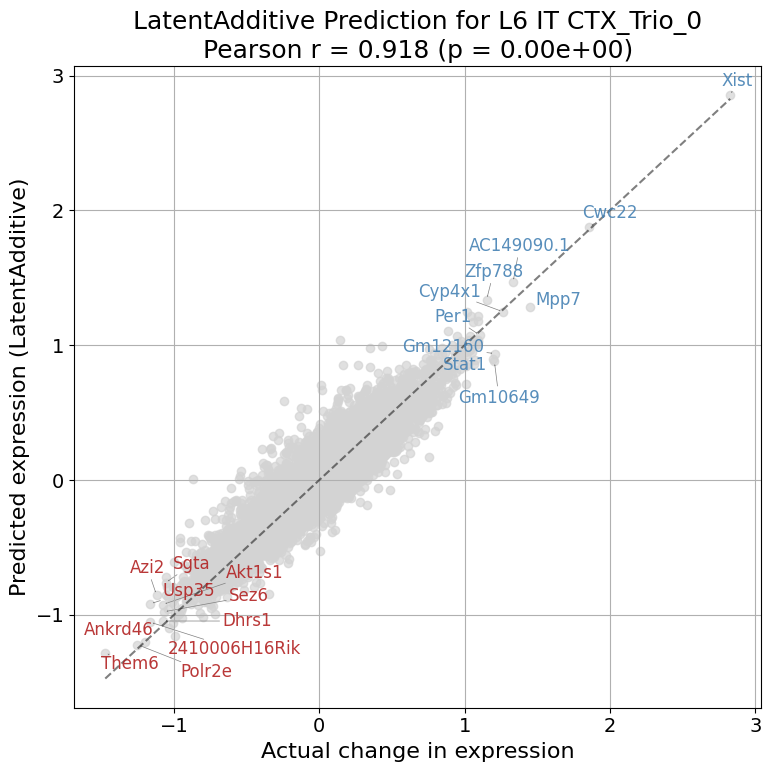

No DEGs found for L6 IT CTX_Trio_0, skipping DEG plot


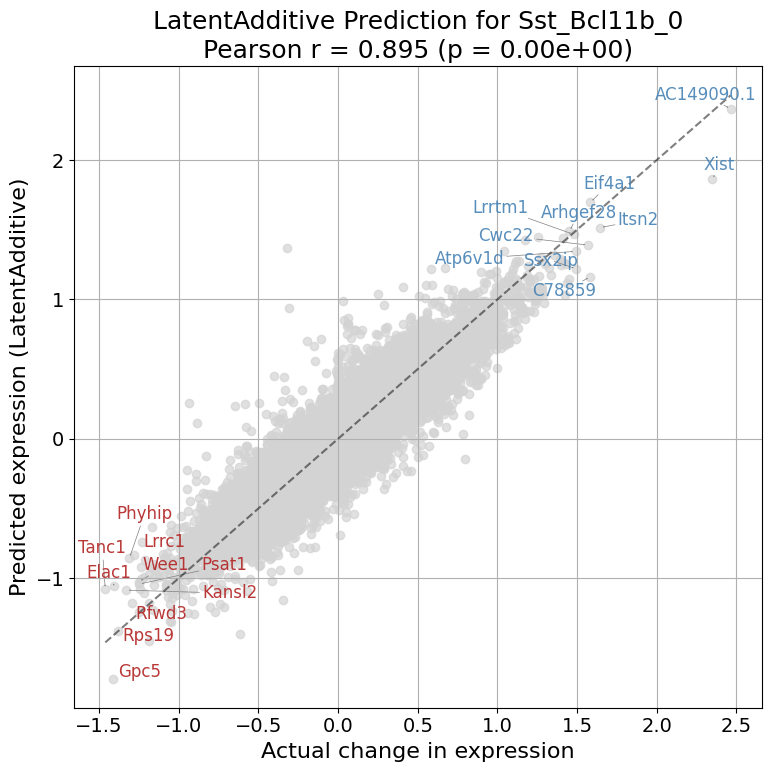

No DEGs found for Sst_Bcl11b_0, skipping DEG plot


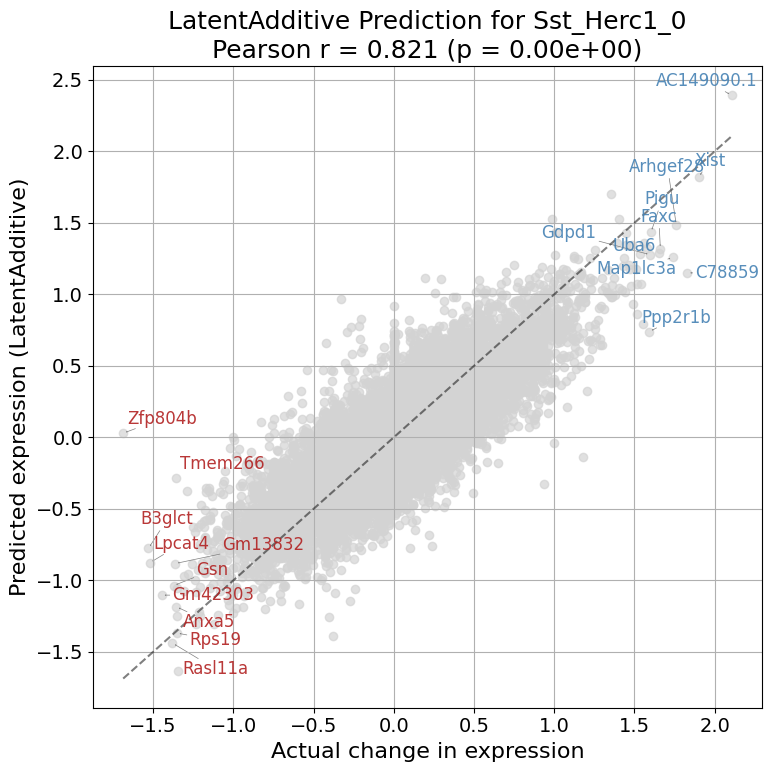

No DEGs found for Sst_Herc1_0, skipping DEG plot


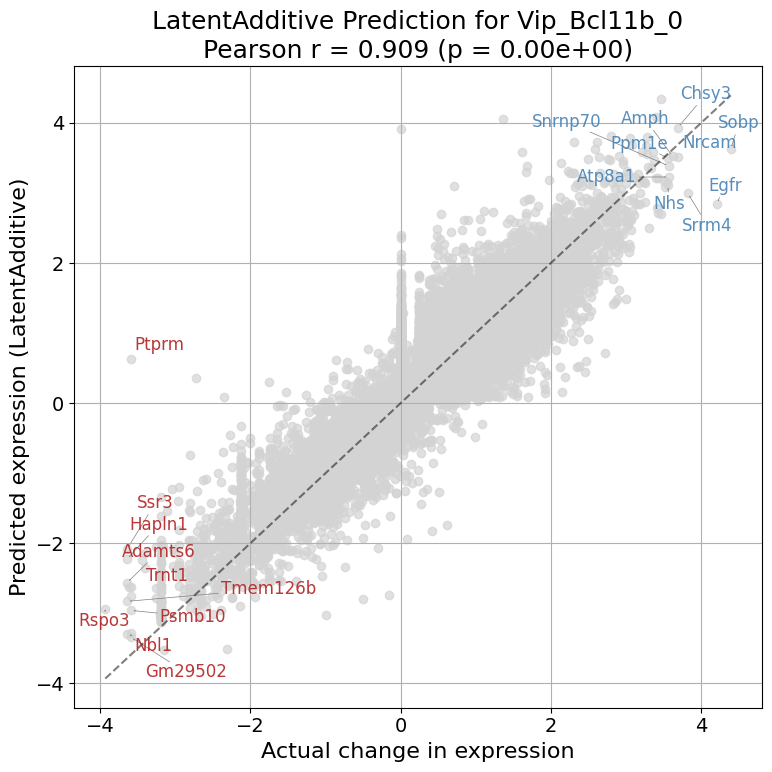

No DEGs found for Vip_Bcl11b_0, skipping DEG plot


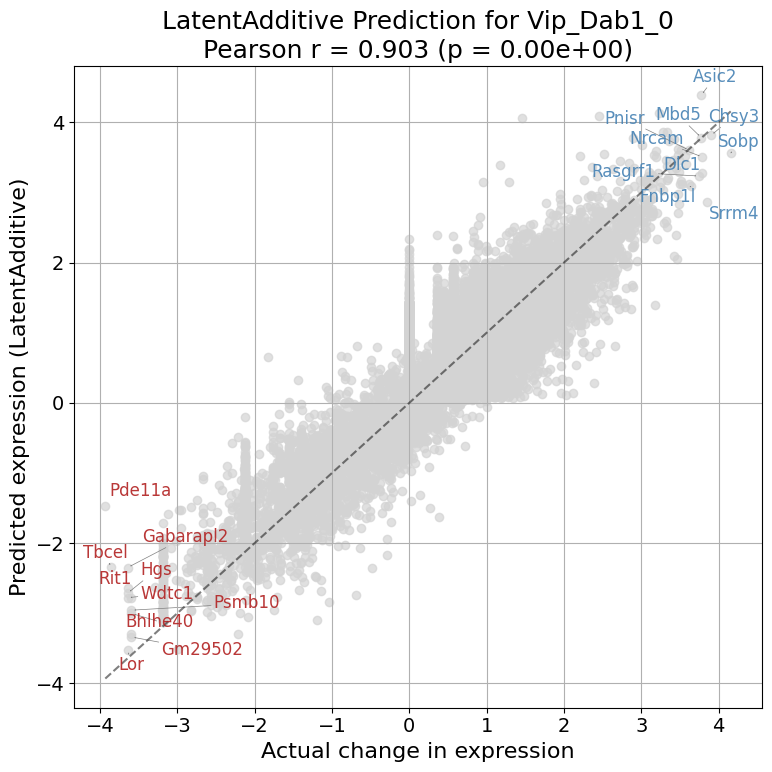

No DEGs found for Vip_Dab1_0, skipping DEG plot


In [14]:
# ============ STYLE CONFIGURATION ============
FIGSIZE = 10  # inches
FONTSIZE_TITLE = 18
FONTSIZE_LABEL = 16
FONTSIZE_ANNOTATION = 10
MARKERSIZE_ALL = 30
MARKERSIZE_DEG = 25
DPI = 300

# Set global font sizes
plt.rcParams.update({
    'font.size': FONTSIZE_LABEL,
    'axes.labelsize': FONTSIZE_LABEL,
    'axes.titlesize': FONTSIZE_TITLE,
    'xtick.labelsize': FONTSIZE_LABEL - 2,
    'ytick.labelsize': FONTSIZE_LABEL - 2,
})
# ============ STYLE CONFIGURATION ============


# STATE latent 2k HVG
boli = sc.read_h5ad('/gpfs/home/asun/jin_lab/perturbench/studies/storm/outputs/test/storm/2025-11-19_16-14-33/data/test_qual_high_amt_high.h5ad')
pkl_res = "/gpfs/home/asun/jin_lab/perturbench/studies/storm/outputs/test/storm/2025-11-19_16-14-33/logs/train/runs/2025-11-19_16-57-53_test_qual_high_amt_high/evaluation/eval.pkl"
model_name = "LatentAdditive"

with open(pkl_res, "rb") as f:
    eval_data = pickle.load(f)
df_pred = eval_data.aggr["logfc"][model_name].to_df()
df_ref = eval_data.aggr["logfc"]["ref"].to_df()
genes = boli.var["gene_name"].values

cell_perts = df_pred.index.tolist()

# Function to load DEG genes for a specific cell type and perturbation
def load_deg_genes(cell_pert):
    """
    Load DEG genes for a specific cell type and perturbation.
    Modify the path pattern to match your file naming convention.
    """
    # Parse cell_pert to extract cell type and perturbation
    # Example: "L6 CT CTX_Tbr1_0" -> cell_type="L6_CT_CTX", perturbation="Tbr1"
    parts = cell_pert.split("_")
    cell_type = "_".join(parts[:-2])  # e.g., "L6 CT CTX"
    perturbation = parts[-2]  # e.g., "Tbr1"
    
    # Construct the DEG file path
    # Adjust this pattern to match your actual file naming convention
    deg_file = f"/gpfs/home/asun/jin_lab/perturbench/raw_data/top100_ctx_{perturbation.lower()}_{cell_type.replace(' ', '_')}.csv"
    
    try:
        deg_df = pd.read_csv(deg_file)
        return set(deg_df["names"].tolist())
    except FileNotFoundError:
        print(f"Warning: DEG file not found for {cell_pert}: {deg_file}")
        return set()

# Plot for each cell_pert individually
for cell_pert in cell_perts:
    # Plot 1: All genes
    fig, ax = plt.subplots(figsize=(8, 8))
    
    x_vals = df_ref.loc[cell_pert].values
    y_vals = df_pred.loc[cell_pert].values
    
    pearson_r, p_value = pearsonr(x_vals, y_vals)

    top10_idx = np.argsort(x_vals)[-10:]
    bottom10_idx = np.argsort(x_vals)[:10]
    top_and_bottom_idx = set(top10_idx).union(set(bottom10_idx))

    ax.scatter(x_vals, y_vals, alpha=0.7, color="lightgray")
    ax.plot([x_vals.min(), x_vals.max()], [x_vals.min(), x_vals.max()], 'k--', alpha=0.5)
    ax.set_xlabel("Actual change in expression")
    ax.set_ylabel(f"Predicted expression ({model_name})")
    ax.set_title(f"{model_name} Prediction for {cell_pert}\nPearson r = {pearson_r:.3f} (p = {p_value:.2e})")
    ax.grid(True)

    texts = []
    for idx in top_and_bottom_idx:
        color = "steelblue" if idx in top10_idx else "firebrick"
        texts.append(
            ax.text(
                x_vals[idx], y_vals[idx], genes[idx],
                fontsize=12,
                color=color,
                alpha=0.9,
                ha='right' if idx in top10_idx else 'left',
                va='bottom'
            )
        )
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5), ax=ax)
    
    plt.tight_layout()
    #plt.savefig(f"{cell_pert}_all_genes.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    # Plot 2: DEGs only for this specific cell_pert
    deg_genes = load_deg_genes(cell_pert)
    
    if len(deg_genes) > 0:
        # Create mask for DEG genes
        deg_mask = np.array([gene in deg_genes for gene in genes])
        deg_indices = np.where(deg_mask)[0]
        
        # Subset dataframes to only DEG genes
        df_pred_deg = df_pred.iloc[:, deg_indices]
        df_ref_deg = df_ref.iloc[:, deg_indices]
        genes_deg = genes[deg_mask]
        
        fig, ax = plt.subplots(figsize=(8, 8))
        
        x_vals_deg = df_ref_deg.loc[cell_pert].values
        y_vals_deg = df_pred_deg.loc[cell_pert].values

        pearson_r, p_value = pearsonr(x_vals_deg, y_vals_deg)

        top10_idx = np.argsort(x_vals_deg)[-10:]
        bottom10_idx = np.argsort(x_vals_deg)[:10]
        top_and_bottom_idx = set(top10_idx).union(set(bottom10_idx))

        # Plot all DEG genes in green
        ax.scatter(x_vals_deg, y_vals_deg, alpha=0.7, color="green", s=20)

        ax.plot([x_vals_deg.min(), x_vals_deg.max()], [x_vals_deg.min(), x_vals_deg.max()], 'k--', alpha=0.5)
        ax.set_xlabel("Actual change in expression")
        ax.set_ylabel(f"Predicted expression ({model_name})")
        ax.set_title(f"{model_name} Prediction for {cell_pert}\nPearson r = {pearson_r:.3f} (p = {p_value:.2e})\nDEGs only (n={len(genes_deg)})")
        ax.grid(True)
        
        # texts = []
        # for idx in top_and_bottom_idx:
        #     color = "steelblue" if idx in top10_idx else "firebrick"
        #     texts.append(
        #         ax.text(
        #             x_vals_deg[idx], y_vals_deg[idx], genes_deg[idx],
        #             fontsize=12,
        #             color=color,
        #             alpha=0.9,
        #             ha='right' if idx in top10_idx else 'left',
        #             va='bottom'
        #         )
        #     )
        # adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5), ax=ax)
        
        plt.tight_layout()
        #plt.savefig(f"{cell_pert}_DEGs_only.png", dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
        
        print(f"Completed plots for {cell_pert}: {len(genes)} total genes, {len(genes_deg)} DEGs")
    else:
        print(f"No DEGs found for {cell_pert}, skipping DEG plot")